<h1 class=bold> Portugesse Banking - Classification Model </h1>

In [ ]:
!pip install lightgbm
!pip install sklearn
!pip install pyjanitor
!pip install pandas
!pip install matplotlib
!pip install xgboost

`### Approach ###`

As stated in the task description we need to build a predictive classification model that will increase our chances of selling the banking product during the next marketing campaign.

`Data`

We will use records with the campaign group flag to build a classifier of a potential new client. The rationale for this is that we don't know what would be an impact of contacting anyone from the control group, even though, some people made a deposit, it was done on their own. Information from the control group may be used but in the different modeling approach.

We should not use any information about call duration, campaign calls, etc. This information would not be available to us while predicting people to call during the next campaign.

`Model creation`

In this step, we will build sklearn pipeline for all needed transformations and use it to test few tree-based models using prepared experiment tracking utilities. We will run a Gridsearch for each model and try to optimize its parameters with a given boundaries.

After founding the best variation in given parameter space, we will blend all models and test if it gives us a boost in the model performance.


`Evaluation`

As an evaluation metric, we will use roc auc because we are trying to find the best 40% of candidates for potential deposits. Other metrics force us to use probability threshold for classification which is redundant for this task. We simply need the best candidates from the given group of people. We will also look if models are not heavily overfitted.

We will create ROC AUC visualization for few best candidates and pick one that will be used in the future campaign.


`Calculating uplift`

Before starting the model creation phase, we will create a holdout set with 20% of the campaign group records which we will not use during training.

After creating a predictive classifier, we will use it to predict 40% of most probable future bank clients from the holdout dataset (new ML-based approach) and compared it with the randomly generated prediction (old approach). 

Uplift coming from using the model will be a difference of successfully predicted labels between those two approaches.

In [1]:
# Data processing
import pandas as pd
import numpy as np
import janitor

from dataclasses import dataclass
import sys
import pathlib
import warnings
from pprint import pprint
from functools import partial

warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.experimental import enable_iterative_imputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Training Pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.impute import IterativeImputer

# Tree models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeRegressor  # For Mice Imputation
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

# Allowing imports from local package
root_dir = pathlib.Path.cwd().parent
sys.path.append(str(root_dir))

from portuguesse_banking.utils import (Results,
                                       run_experiment,
                                       get_best_models_for_each_estimator_type,
                                       get_results_as_dataframe,
                                       calculate_roc_auc,
                                       calculate_fpr_tpr,
                                       draw_roc)

# Data

`Loading raw data`

As flagged in the description, we will use only the campaign group. This is the only source that contains labeled information about the impact of the call. 

We will also filter it using __duration == 0__ filter to drop observations where the call doesn't happen (2 observations)

In [2]:
# We will start from the raw data
full_dataset = (pd.read_csv(filepath_or_buffer=root_dir.joinpath('data/bank_data_prediction_task.csv'),
                            index_col=0,
                            low_memory=False)
                .clean_names())  # changing "." to "_" and doing lower()

data = (full_dataset
        [full_dataset['test_control_flag'] == 'campaign group']
        .drop('test_control_flag', axis=1)
        .query('`duration` > 0'))

data.shape

(16474, 21)

`Data Preparation`

This part will not be a part of the modeling pipeline. In my opinion, it should be an ETL step. Binning might be done using some other strategies (like setting intervals using Decision Tree) but considering why we are doing the binning (handling imputation with '999' and dealing with '0' as call doesn't happen) we will stick with the current implementation and create some of the transformations using the script below.

In [3]:
data['poutcome'] = np.where(data['poutcome'] == 'nonexistent', np.NaN, data['poutcome'])

data['previous'] = pd.cut(np.array(data['previous']),
                          bins= [-1, 0, 1, 10],
                          labels=["not_called", 'called_one_time', 'called_more_then_one_time'])
   


data['pdays'] = pd.cut(data['pdays'],
                       bins=[-0.001, 3.0, 6.0, 7.0, 998, 1000],  # intervals set during EDA
                       labels=['less then 3', '3-6', '6-7', 'more then 7', 'no previous contact'])

def replace_unknown_to_npnan(series):
    return np.where(data[feature] == 'unknown', np.NaN, data[feature])

for feature in ['housing', 'loan', 'default', 'job']:  # Nulls will be handled by GetDummies
    data[feature] =replace_unknown_to_npnan(data[feature])

`Holdout Set`

We will start with splitting the data and creating the holdout set. This way, we will prevent any possible data leakage. The holdout set will be used in the final evaluation and uplift calculation.

In [4]:
y = data['y'].map({'yes': 1, 'no': 0})
X = data.drop(['y'], axis=1)  # target

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# Model creation

`Data Pipeline`

We will create two pipeline components: 

    - :preprocessing: with PCA, OneHotEncoding, and 'age' normalization.
    
    - :imputation: with MICE Imputer based on DecissionTree
    
the final step will contain an estimator which will calculate the probability of success for a given client.

Pipelines will work on numpy arrays instead of pandas dataframe. During the real implementation, we might want to create two types of pipelines to have a possibility for checking the model feature importances or shap values on specific predictions.

In [75]:
preprocessing = make_column_transformer(
                        (PCA(), ['euribor3m', 'emp_var_rate', 'nr_employed']),
                        (PowerTransformer("box-cox"), ['age']),
                        (OneHotEncoder(handle_unknown='ignore', sparse=False),
                                     ['job', 'marital', 'education', 'default', 'housing', 'loan','previous', 'poutcome']),
                        (FunctionTransformer(lambda x:x), ['cons_price_idx', 'cons_conf_idx']),  # passthrough without transformation
                         remainder='drop'
)

imputation = IterativeImputer(estimator=DecisionTreeRegressor())

__Utilities used__:

- `Result` : Dataclass for holding each model parameters and evaluation metrics
- `run_experiment` : Running GridSearch with given setup and returning list of Result objects
- `get_results_as_dataframe`: Create Dataframe from list of Results
- `get_best_models_for_each_estimator_type` : utility function to evaluate and extract best settings of each experiment

`Setting and running experiments` 

EDA showed us that there are multimodal distribution of important features: cons_price_idx and cons_conf_idx.
Linear model might have a problem with those, so we will try only tree based models. In my opinion they will grasp all the valuable information from those features.

Last experiment will blend all previously found model as a StackingClassifier. It might give us a slightly boost of predictive power.

In [ ]:
estimator = partial(make_pipeline, preprocessing, imputation)  # function that will add given estimator and return
                                                               # whole pipeline 
    
all_results = []  # list for Result objects

rf = {'pipeline': estimator(RandomForestClassifier()),
      'param_grid': [{'randomforestclassifier__n_estimators': [150, 250, 350, 450],
                      'randomforestclassifier__max_depth':[7, 9, None],
                      'randomforestclassifier__min_samples_leaf': [1, 10, 30]
                      }]}

lgbm = {'pipeline': estimator(LGBMClassifier()),
        'param_grid': [{'lgbmclassifier__n_estimators': [150, 250, 350],
                        'lgbmclassifier__colsample_bytree': [0.6, 0.8],
                        'lgbmclassifier__learning_rate': [0.1, 0.01],
                        'lgbmclassifier__subsample': [0.6, 0.8]}]}

boosting = {'pipeline': estimator(GradientBoostingClassifier()),
            'param_grid': [{'gradientboostingclassifier__learning_rate': [0.1, 0.01, 0.005],
                            'gradientboostingclassifier__n_estimators': [150, 250, 350],
                            'gradientboostingclassifier__subsample': [0.8, 0.6]}]}

xgboost = {'pipeline': estimator(XGBClassifier(use_label_encoder=False)),
            'param_grid': [{'xgbclassifier__n_estimators': [150, 250, 350],
                            'xgbclassifier__learning_rate': [0.1, 0.01],
                            'xgbclassifier__colsample_bytree': [0.8, 0.6],
                            'xgbclassifier__max_depth':[3, 4, 6]}]}

for experiment in [rf, lgbm, boosting, xgboost]:
    all_results += run_experiment(data=X_train, target=y_train, **experiment)

The Next step will instantiate all best variation of each used model and try to use them in the stacking classifier.

In [76]:
best_model_params = get_best_models_for_each_estimator_type(all_results)

rf_best = ('rfc', RandomForestClassifier(**best_model_params['RandomForestClassifier']))
lgbm_best = ('lgbm', LGBMClassifier(**best_model_params['LGBMClassifier']))
boosting_best = ('boosting', GradientBoostingClassifier(**best_model_params['GradientBoostingClassifier']))
xgboost_best = ('xgboost', XGBClassifier(use_label_encoder=False, **best_model_params['XGBClassifier']))

In [ ]:
stacked_estimator = StackingClassifier(estimators=[xgboost_best, rf_best, lgbm_best],
                                       final_estimator=boosting_best[1],
                                       cv=4,
                                       passthrough=True)

blending = {'pipeline': estimator(stacked_estimator),
            'param_grid': [
                {'stackingclassifier__estimators': [
                    [xgboost_best, rf_best, lgbm_best],
                    [rf_best, lgbm_best],
                    [xgboost_best],
                    [rf_best],
                    [lgbm_best]],
                 'stackingclassifier__passthrough': [False, True]
                }
            ]}                         

all_results += run_experiment(data=X_train, target=y_train, **blending)

In [80]:
best_model_params = get_best_models_for_each_estimator_type(all_results)

stacked_best = ('blend', StackingClassifier(**best_model_params['StackingClassifier']))

In [79]:
(pd.DataFrame([result.__dict__ for result in all_results])
 .sort_values('roc_auc_test')
 .drop_duplicates(subset=['model'], keep='last')
 .drop('params', axis=1))

model  roc_auc_train  roc_auc_test
18       RandomForestClassifier       0.785255      0.728460
71   GradientBoostingClassifier       0.749227      0.729171
110               XGBClassifier       0.764470      0.729834
45               LGBMClassifier       0.811763      0.729995
119          StackingClassifier       0.766720      0.731503

# Evaluation

__Utilities used__:

- `draw_roc` : add roc_curve to the given axis
- `calculate_fpr_tpr` : Calculate false positive and true positive rate for different classification thresholds
- `calculate_roc_auc`: Calculate roc_auc score for given model, data, and target

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=0.25, random_state=42)

In [ ]:
trained_models = dict()
for model in [rf_best, lgbm_best, boosting_best, xgboost_best, stacked_best]:
    trained_models[model[0]] = estimator(model[1]).fit(X_train, y_train)

In [84]:
for name, model in trained_models.items():
    print(f'{name}, Train: {calculate_roc_auc(model, X_train, y_train)}, Test: {calculate_roc_auc(model, X_test, y_test)}')

rfc, Train: 0.789, Test: 0.736
lgbm, Train: 0.816, Test: 0.73
boosting, Train: 0.749, Test: 0.738
xgboost, Train: 0.766, Test: 0.734
blend, Train: 0.72, Test: 0.721


Text(0.5, 1.0, 'ROC for test data')

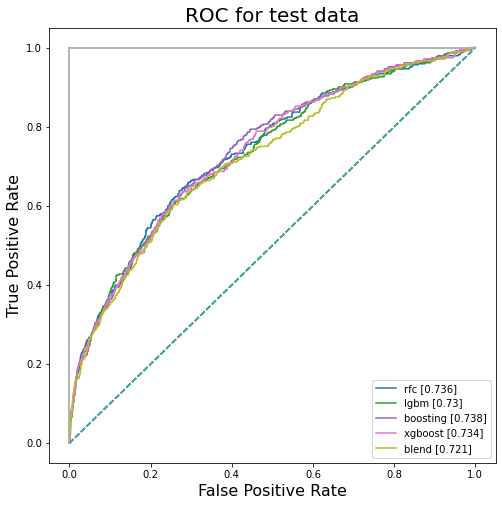

In [85]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
for name, model in trained_models.items():
    draw_roc(f'{name} [{calculate_roc_auc(model, X_test, y_test)}]', *calculate_fpr_tpr(model, X_test, y_test), ax=ax)

plt.title("ROC for test data", size=20)

Text(0.5, 1.0, 'ROC for train data')

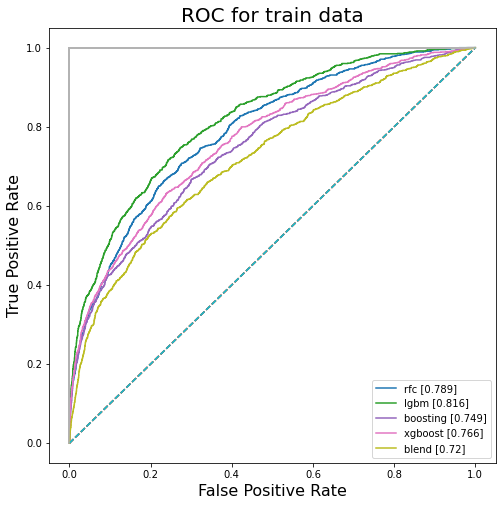

In [86]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
for name, model in trained_models.items():
    draw_roc(f'{name} [{calculate_roc_auc(model, X_train, y_train)}]', *calculate_fpr_tpr(model, X_train, y_train), ax=ax)

plt.title("ROC for train data", size=20)

Considering very similiar performance on the test data, we will use model that has the lowest score on the train dataset. Lower metric on traning set means that model should generalize better.

Our final estimator will be `GradientBoostingClassifier` implemented in sklearn.

# Calculating uplift

In [87]:
(full_dataset
 .assign(y=full_dataset['y'].map({'yes':1, 'no':0}))
 .groupby('test_control_flag')
 .agg({'y': ('mean', 'sum', 'count')})
 .round(3))

y             
                    mean   sum  count
test_control_flag                    
campaign group     0.151  2484  16476
control group      0.109  2684  24712

In the last campaign, success rate of marketers calls was around 15%. We will assume that this rate is fixed, and would repeat on any other data.


We will treat our holdout set as evaluation dataset.

We know which clients made a deposit in our bank, so we know what would be an outcome of targeting the call on them.

We will compare our classifier with random quess and count correctly predicted successes on 40% of this data (campaign reach). Differance in our success rate is our predicted uplift gained by using the model.

`Calculating uplift on 40% of the dataset`

In [88]:
def calculate_success_rates(model, percent_of_dataset):
    marketing_targets_len = int(len(y_holdout) * percent_of_dataset)
    prediction = model.predict_proba(X_holdout)[:, 1]
    print("Success rate for different approaches:\n")
    score = sorted(list(zip(prediction, y_holdout)), key= lambda x: x[0], reverse=True)
    score = [y_label for _, y_label in score[:marketing_targets_len]]
    score = (sum(score) / marketing_targets_len)
    print('ML Model', f'{round(score * 100, 1)}%')
    print('Random', f'{round(y_holdout.mean() * 100, 1)}%')
    
    return score

In [89]:
score = calculate_success_rates(model, 0.4)

Success rate for different approaches:

ML Model 23.1%
Random 14.8%


We know that the overall succes rate of Random Selection was aprox. 15.1% but if we want to compare it to the model, we need to use the same dataset.

Now, knowing what is the model approximate success rate, we can use it to calculate estimated gains from the next campaign which will be run on the whole dataset.

In [90]:
ml_model_rate = score
random_rate = 0.151

campaign_reach = full_dataset.shape[0] * 0.4

ml_model_successes = int(ml_model_rate * campaign_reach)
random_successes = int(random_rate * campaign_reach)

print('Old approach:', random_successes)
print('ML approach', ml_model_successes)
print()
print('Additional successes:', int(campaign_reach * (ml_model_rate - random_rate)))
print('Improvement in %:' , round((ml_model_successes - random_successes) / random_successes * 100, 2))

Old approach: 2487
ML approach 3800

Additional successes: 1312
Improvement in %: 52.79


<h3 style="color:green"> ML Model would improve the previous campaign performance by almost 53% which coresponds to 1312 additional clients <h3>

# What's next?

1) Expanding the dataset. We don't have any information about people sex, a region where they live, or even broader history of using the bank services in the past (or even present information: his balance, credits, etc)

2) Expand the dataset using feature engineering

3) Experiment with neural nets and try to combine it with the final model. The completely different model design may find some additional things in the data and boost the model performance.

4) Analyze what may be the factors for using bank services in the control group and try to call people who have the highest probability for getting the deposit by themself.

5) Client segmentation and analyzing profitability between the groups. Targeting is important, but it's better to call clients that provide higher profit to the company

6) Analyze post-campaign data about call duration, frequency, way of contact and give insights to the telemarketing team to boost their success rate

7) Optimizing how big a campaign should be to still be profitable

8) Test the model on the next campaign -> gather new information -> retrain the model 